# Implementation of time blocking for compression/serialization and de-serialization/de-compression of wavefields with Devito operators

## Compression note -- use of ```blosc```

In this notebook we use ```blosc``` compression that is not loaded by default in devito. The first operational cell in the notebook uses the jupyter notebook *magic* command shown below to install the ```blosc``` compression library and python wrapper, which may require compilation. 

```
import sys
!{sys.executable} -m pip install blosc
```

Note that ```blosc``` provides *lossless compression*, and in practice one uses *lossy compression* to achieve significantly better compression ratios. Consider the use of ```blosc``` as a placeholder for your compression method of choice, providing all essential characteristics of what might be used at scale. 

```blosc``` Reference:
* c project and library: https://blosc.org
* python wrapper: https://github.com/Blosc/python-blosc
* python wrapper documentation: http://python-blosc.blosc.org

## Introduction 

The goal of this tutorial is to prototype the compression/serialization and de-serialization/de-compression for wavefields in Devito. The motivation is using seismic modeling operators for full waveform inversion (FWI). Some of the steps in FWI require the use of previsouly computed wavefields, and of particular interest the adjoint of the Jacobian linearized operator -- an operator that maps data perturbation into velocity perturbation -- requires a zero-lag temporal correlation with the wavefield that is computed with the nonlinear source. 

There are implemented alternatives to serialization/de-serialization like checkpointing (link to nb?), but we investigate the serialization option here. 

We aim to provide a *proof of concept* for compression/serialization and de-serialization/de-compression of the nonlinear wavefield. We will achieve this via _time blocking_: we will run a number of time steps in the generated c kernel, and then return control to python for compression/serialization and de-serialization/de-compression operations.

In order to illustrate the use case for serialization, we write the workflow for computing the gradient of the FWI objective function, ignoring a lot of details, as follows:

1. Generate the nonlinear forward modeled data at the receivers $d_{mod}$
$$ 
d_{mod} = F m 
$$

1. Compress and serialize the nonlinear source wavefield to disk during computation of 1. The entire nonlinear wavefield is of size $[nt,nx,nz]$ in 2D, but we deal with a block of $M$ time steps at a time, so the size of the chunk to be compressed and serialized is $[M,nx,nz]$. 

1. Compute the data residual $\delta r$ by differencing observed and modeled data at the receivers 
$$
\delta r = d_{obs} - d_{mod}
$$

1. Backproject the data residual $\delta r$ via time reversal with the adjoint linearized Jacobian operator.

1. De-serialize and de-compress the nonlinear source wavefield from disk during computation in step 4, synchronizing time step between the nonlinear wavefield computed forward in time and time reversed adjoint wavefield. We will deal with de-serialization and de-compression of chunks of $M$ time steps of size $[M,nx,nz]$.

1. Increment the model perturbation via zero lag correlation of the de-serialized nonlinear source wavefield and the backprojected receiver adjoint wavefield. Note that this computed model perturbation is the  _gradient_ of the FWI objective function.
$$
\delta m = \bigl( \nabla F\bigr)^\top\ \delta r
$$

Please see other notebooks in this directory for more details, in particular the notebooks describing the self-adjoint modeling operators. More information: 
* Nonlinear operator ([sa_01_iso_implementation1.ipynb](sa_01_iso_implementation1.ipynb))
* Linearized operators ([sa_02_iso_implementation2.ipynb](sa_02_iso_implementation2.ipynb)).

## Outline 
1. Define symbols
1. Description of tests to verify correctness
1. Description of use of ```Buffer``` in ```TimeFunction``` to implement time blocking
1. Ensure ```python-blosc``` compression is installed
1. Create small 2D test model
1. Implement and test the Nonlinear forward operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Implement and test the Jacobian linearized forward operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Implement and test theJacobian linearized adjoint operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Discussion

## Table of symbols

We show the symbols here relevant to the implementation of the linearized operators.

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $m_0(x,y,z)$ | Reference P wave velocity    | function of space |
| $\delta m(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $\delta r(t,x,y,z)$ | Receiver wavefield perturbation | function of time, localized in space to receiver locations |
| $F[m]\ q$ | Forward linear modeling operator | Nonlinear in $m$, linear in $q, s$: $\quad$ maps $q \rightarrow s$ |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta m$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta m \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta m$ |

## Description of tests to verify correctness

In order to make sure we have implemented these operators correctly, we will numerically compare the output from two runs:
1. all time steps saved implementation 
1. time blocking plus compression/serialization implementation

We perform these tests for three phases of FWI modeling:
1. nonlinear forward (maps model to data)
1. Jacobian linearized forward (maps model perturbation to data perturbation)
1. Jacobian linearized adjoint (maps data perturbation to model perturbation)

We will design the small 2D test experiment with a source in the middle of the model and short enough elapsed modeling time that we do not need to worry about boundary reflections for these tests. 

## Use of ```Buffer``` to implement time blocking

We will use a ```Buffer``` of size $M$ in our time blocking implementation. This means that space is allocated for spatial wavefields at $M$ time steps, each spatial wavefield of size $[nx,nz]$. The ```Buffer``` then cycles through the allocated time steps as the modeling evolves, using *modulo indexing*. 

### Modulo indexing for a second order in time PDE
Below we demonstrate time blocking with a second order in time PDE, which requires two wavefields in order to advance in time. In a second order system the wavefield at the next time step $u(t+\Delta t)$ is defined as a function of the wavefield at current time step $u(t)$ and the wavefield at previous time step $u(t-\Delta t)$.

Devito uses modulo indexing with ```Buffer``` for indexing into $u$ of fixed size. We show below the code generated by devito for a ```Buffer``` of size 5, with time indices ```t0``` (current time step), ```t1``` (next time step), and ```t2``` (previous time step) as a function of the temporal loop index ```time```. Note that we have simplified the generated code by breaking a single for loop specification line into multiple lines for clarity. We have also added comments to help understand the mapping of indices.

```
for (int time = time_m; time <= time_M; time += 1) {
  t0 = (time + 0)%(5);    // time index for the current time step 
  t1 = (time + 1)%(5);    // time index for the next time step
  t2 = (time + 4)%(5);    // time index for the  previous time step
  
  // ... PIE: propagation, source injection, receiver extraction ...
}

```

It is important to note that for a second order system the minimum allowed time index ```time_m``` will be $1$, because starting at $0$ would imply that the previous time step wavefield $u(t-\Delta t)$ exists at time index $-1$. 

Similarly, the maximum allowed time index ```time_M``` will be $nt-2$, because the next time step $u(t+\Delta t)$ is set at time index $nt-1$.   

### Demonstration of modulo indexing for a sequence of time steps

We next look at the time indices for a sequence of 15 time steps starting from time index $1$. We are blocking $M=5$ time steps, so the ```TimeFunction``` for the wavefield $u$ was initialized as ```u = TimeFunction(..., Buffer(5))```. We will show the loop index for time steps ```time``` and the modulo 5 time indices ```t0```, ```t1```, ```t2```, with the time blocking intervals of $M$ time steps each demarcated with horizontal lines. 

$$
\scriptsize
\begin{matrix}
\text{time block} & & \text{time} & & \text{modulo t0} & & \text{modulo t1} & & \text{modulo t2} \\ 
\hline
  & \; &  1 & \; &  1 & \; &  2 & \; &  0 \\
  & \; &  2 & \; &  2 & \; &  3 & \; &  1 \\
1 & \; &  3 & \; &  3 & \; &  4 & \; &  2 \\
  & \; &  4 & \; &  4 & \; &  0 & \; &  3 \\
  & \; &  5 & \; &  0 & \; &  1 & \; &  4 \\
\hline
  & \; &  6 & \; &  1 & \; &  2 & \; &  0 \\
  & \; &  7 & \; &  2 & \; &  3 & \; &  1 \\
2 & \; &  8 & \; &  3 & \; &  4 & \; &  2 \\
  & \; &  9 & \; &  4 & \; &  0 & \; &  3 \\
  & \; & 10 & \; &  0 & \; &  1 & \; &  4 \\
\hline
  & \; & 11 & \; &  1 & \; &  2 & \; &  0 \\
  & \; & 12 & \; &  2 & \; &  3 & \; &  1 \\
3 & \; & 13 & \; &  3 & \; &  4 & \; &  2 \\
  & \; & 14 & \; &  4 & \; &  0 & \; &  3 \\
  & \; & 15 & \; &  0 & \; &  1 & \; &  4 \\
\hline
\end{matrix}
$$

Observe how the modulo time index ```t1``` for the next time step $u(t+\Delta t)$ is one more than the time index ```t0``` for the current time step $u(t)$, and the modulo time index ```t2``` for the previous time step $u(t-\Delta t)$ is one less than the time index ```t0``` for the current time step $u(t)$, with the exception of when modulo indexing for the ```Buffer``` wraps around.

What is most important about this is recognizing when the modulo indiexing wraps around for a ```Buffer``` of particular size. The practical outcome is that if you start from time index 1 and assign a block of $M$ time steps computed using ```Buffer``` to a contiguous array (or disk storage) you will need use two assignment statements, for example:
 1. modulo indices 1 through 4, the first four time steps, which map to ```Buffer``` indicies 1-4.
 2. modulo index M, which maps to ```Buffer``` index 0

### Considerations for correctness testing and serialization 

For the purpose of testing correctness against a wavefield computed by saving all time steps, we will use the two assignment statements as shown above to assign all $M$ times slices from the ```Buffer```. 

However, when we compress and serialize it makes sense to use the block of $M$ time steps in the ```Buffer``` directly with a single assignment, even if not contiguous in time. There may be some small impact on compression due to the discontinuity associated with ```Buffer``` element 0 corresponding to time index 5 and ```Buffer``` element 1 corresponding to time index 1. We have not explored this and will ignore for the purpose of this notebook.

## Ensure that ```blosc``` is installed

In [1]:
# Install pyzfp package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install blosc
import blosc

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [2]:
from scipy.special import hankel2
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis, Model, AcquisitionGeometry
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration, norm, Buffer)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.self_adjoint import (acoustic_sa_setup, setup_w_over_q,
                                           SaIsoAcousticWaveSolver)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

## Instantiate the model for a two dimensional problem
 - We use a small 500x500 m. model
 - We use 10x10 m. discretization 
 - We choose modeling sample rate explicitly (2 msec)
 - We use a modeling time range of 1 second
 - We use a wholespace model
   - velocity: 1500 m/s
   - density: 1 g/cm^3
 - We place the source in the center of the model
 - We use a vertical line of receivers right of center in model
 - We use the visco-acoustic absorbing boundary logic from the self-adjoint operators linked above, and add a 50 point absorbing boundary
 - We also generate a velocity perturbation that will be used in the linearized forward Jacobian operator

In [3]:
# NBVAL_IGNORE_OUTPUT

# Define dimensions for the interior of the model
nx,nz = 501,501
npad = 50
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define the dimensions 
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))

# Initialize the Devito grid 
dtype = np.float32
grid = Grid(extent=extent, shape=shape, origin=origin, dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

# Create velocity and buoyancy fields. 
space_order = 8
m0 = Function(name='m0', grid=grid, space_order=space_order)
b = Function(name='b', grid=grid, space_order=space_order)
m0.data[:] = 1.5
b.data[:,:] = 1.0 / 1.0

# Perturbation to velocity: a square offset from the center of the model
dm = Function(name='dm', grid=grid, space_order=space_order)
size = 10
x0 = (nx-1)//2
z0 = (nz-1)//2
dm.data[:] = 0.0
dm.data[x0-size:x0+size, z0-size:z0+size] = 1.0

# Initialize the attenuation profile for the absorbing boundary
fpeak = 0.010
w = 2.0 * np.pi * fpeak
qmin = 0.1
wOverQ = Function(name='wOverQ_025', grid=grid, space_order=space_order)
setup_w_over_q(wOverQ, w, qmin, 100.0, npad)

# Time sampling
t0 = dtype(0)     # Simulation time start
tn = dtype(500)  # Simulation time end (1 second = 1000 msec)
dt = dtype(2)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num
print("")
print("time_range; ", time_range)

# Source in the center of the model at 10 Hz center frequency
# Note we make two copes, one for save all and one for  time blocking
src1 = RickerSource(name='src1', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src2 = RickerSource(name='src2', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src1.coordinates.data[0,0] = dx * ((nx-1) / 2 - 20)
src1.coordinates.data[0,1] = dz * (nz-1) / 2
src2.coordinates.data[0,0] = dx * ((nx-1) / 2 - 20)
src2.coordinates.data[0,1] = dz * (nz-1) / 2

# line of receivers along the right edge of the model
# Note we make two copes, one for save all and one for  time blocking
rec1 = Receiver(name='rec1', grid=grid, npoint=nz, time_range=time_range)
rec1.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec1.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

rec2 = Receiver(name='rec2', grid=grid, npoint=nz, time_range=time_range)
rec1.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec2.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("")
print("src_coordinate  X;         %+12.4f" % (src1.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src2.coordinates.data[0,1]))
print("rec_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec1.coordinates.data[:,0]), np.max(rec1.coordinates.data[:,0])))
print("rec_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec1.coordinates.data[:,1]), np.max(rec1.coordinates.data[:,1])))

shape;            (501, 501)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (5000.0, 5000.0)

grid.shape;       (501, 501)
grid.extent;      (5000.0, 5000.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


Operator `WOverQ_Operator` run in 0.01 s



time_range;  TimeAxis: start=0, stop=500, step=2, num=251

src_coordinate  X;           +2300.0000
src_coordinate  Z;           +2500.0000
rec_coordinates X min/max;   +2700.0000   +2700.0000
rec_coordinates Z min/max;      +0.0000   +5000.0000


## Plot velocity and density models

Next we plot the velocity and density models for illustration, with source location shown as a large red asterisk and receiver line shown as a black line.

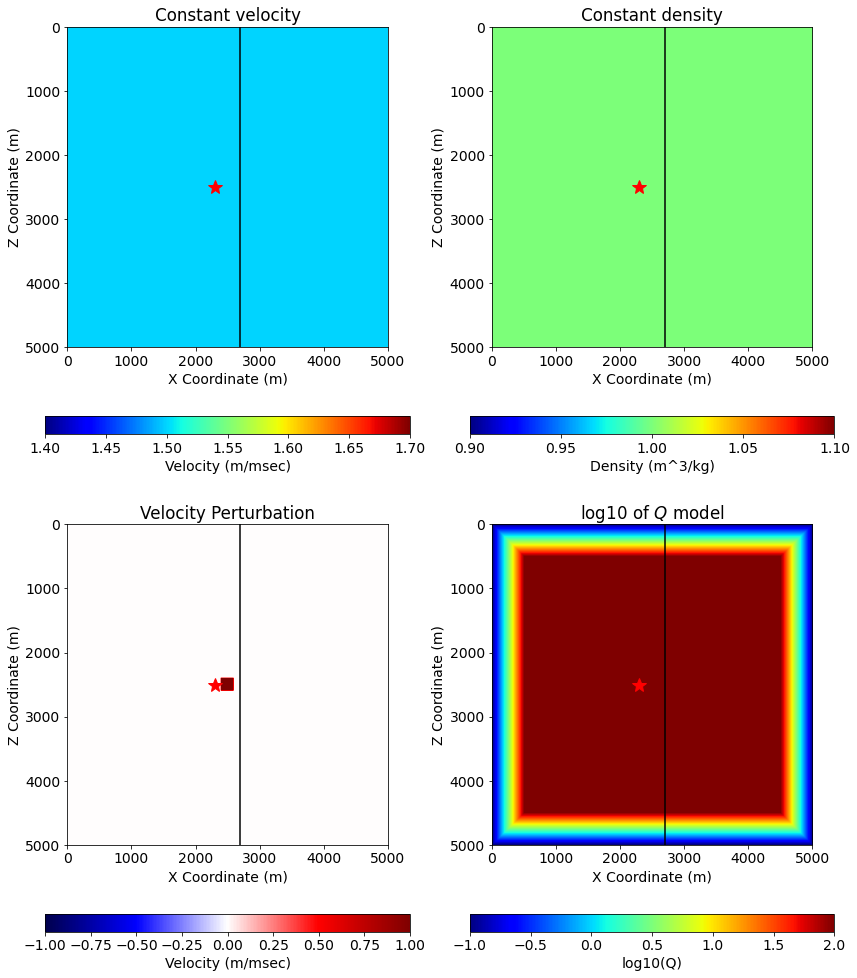

In [4]:
# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin[0], origin[0] + extent[0], origin[1] + extent[1], origin[1]]

vmin, vmax = 1.4, 1.7
pmin, pmax = -1, +1
dmin, dmax = 0.9, 1.1

plt.figure(figsize=(12,14))

# plot velocity 
plt.subplot(2, 2, 1)
plt.imshow(np.transpose(m0.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant velocity")

# plot density
plt.subplot(2, 2, 2)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Density (m^3/kg)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant density")

# plot velocity perturbation
plt.subplot(2, 2, 3)
plt.imshow(np.transpose(dm.data), cmap="seismic", 
           vmin=pmin, vmax=pmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Velocity Perturbation")

# Plot the log of the generated Q profile
q = np.log10(w / wOverQ.data)
lmin, lmax = np.log10(qmin), np.log10(100)

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(q.data), cmap=cm.jet, vmin=lmin, vmax=lmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='log10(Q)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q$ model")

plt.tight_layout()
None

## Time blocking implementation of nonlinear forward

### Save all time steps implementation

We borrow the stencil from the self-adjoint operators shown in the jupyter notebooks linked above. 

When we instantiate the ```TimeFunction``` $u$ we pass the argument ```save=nt``` which allocates memory for ```nt``` time steps.

In [5]:
# NBVAL_IGNORE_OUTPUT

# Create a TimeFunction saving all time steps
u1 = TimeFunction(name="u1", grid=grid, time_order=2, space_order=space_order, save=nt)
t,x,z = u1.dimensions

# Source terms (see notebooks linked above for more detail)
src1_term = src1.inject(field=u1.forward, expr=src1 * t.spacing**2 * m0**2 / b)
rec1_term = rec1.interpolate(expr=u1.forward)

# Time update equation (see notebooks linked above for more detail)
eq_time_update1 = (t.spacing**2 * m0**2 / b) * \
    ((b * u1.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u1.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u1 + \
    (t.spacing * wOverQ - 1) * u1.backward

stencil1 = Eq(u1.forward, eq_time_update1)

# Update spacing_map (see notebooks linked above for more detail)
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Build and run the Operator
# Note the first time sample we run is 1, and the last is nt-2 
op1 = Operator([stencil1] + src1_term + rec1_term, subs=spacing_map)
op1(time_m=1, time_M=nt - 2)
# print(op1)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 2.0}


Operator `Kernel` run in 0.27 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.2603579999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=5.2999999999999947e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.002193000000000004, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [6]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
print(norm(u1))
print(norm(rec1))
assert np.isclose(norm(u1), 2229.983, atol=0, rtol=1e-3)
assert np.isclose(norm(rec1), 154.825, atol=0, rtol=1e-3)

2229.9753
154.82512


### Time blocking implementation

We now will instantiate a ```TimeFunction``` $u2$ that uses a ```Buffer``` for saving time steps. We choose the buffer size $M$, hopefully a reasonable number in practice that would allow time-tiling but still not create too large a memory footprint for $u2$.

In [7]:
# Create a TimeFunction using a Buffer to save only M time steps
M = 5
u2 = TimeFunction(name="u2", grid=grid, time_order=2, space_order=space_order, save=Buffer(M))

# Source and receiver terms (see notebooks linked above for more detail)
src2_term = src2.inject(field=u2.forward, expr=src2 * t.spacing**2 * m0**2 / b)
rec2_term = rec2.interpolate(expr=u2.forward)

# We need to regenerate the time update equation with the new TimeFunction in order
# to get the time handling correct
eq_time_update2 = (t.spacing**2 * m0**2 / b) * \
    ((b * u2.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u2.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u2 + \
    (t.spacing * wOverQ - 1) * u2.backward

stencil2 = Eq(u2.forward, eq_time_update2)

# Update spacing_map (see notebooks linked above for more detail)
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Build the Operator 
op2 = Operator([stencil2] + src2_term + rec2_term, subs=spacing_map)
# print(op2)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 2.0}


### Run loop over blocks of M time steps

Here we will run over blocks of $M$ time steps, where:
* the total number of time steps $nt$ 
* the number of time steps in a time block $M$ 
* the total number of time blocks is $N = 1 + (nt-1)\ /\ M$

$$
\scriptsize
\begin{matrix}
\text{time block} & & \text{time} & & \text{modulo t0} & & \text{modulo t1} & & \text{modulo t2} \\ 
\hline
  & \; &  1 & \; &  1 & \; &  2 & \; &  0 \\
  & \; &  2 & \; &  2 & \; &  3 & \; &  1 \\
1 & \; &  3 & \; &  3 & \; &  4 & \; &  2 \\
  & \; &  4 & \; &  4 & \; &  0 & \; &  3 \\
  & \; &  5 & \; &  0 & \; &  1 & \; &  4 \\
\hline
  & \; &  6 & \; &  1 & \; &  2 & \; &  0 \\
  & \; &  7 & \; &  2 & \; &  3 & \; &  1 \\
2 & \; &  8 & \; &  3 & \; &  4 & \; &  2 \\
  & \; &  9 & \; &  4 & \; &  0 & \; &  3 \\
  & \; & 10 & \; &  0 & \; &  1 & \; &  4 \\
\hline
  & \; & 11 & \; &  1 & \; &  2 & \; &  0 \\
  & \; & 12 & \; &  2 & \; &  3 & \; &  1 \\
3 & \; & 13 & \; &  3 & \; &  4 & \; &  2 \\
  & \; & 14 & \; &  4 & \; &  0 & \; &  3 \\
  & \; & 15 & \; &  0 & \; &  1 & \; &  4 \\
\hline
\end{matrix}
$$

The next cell that exercises the time blocking operator. At the end of execution, we test the correctness by measuring the norm of the difference between the ```Buffer``` implementation and the save all time steps implementation.

In [15]:
# NBVAL_IGNORE_OUTPUT

# We make an array the full size in order to save the time blocked wavefield
# for comparison with u1 above
u2_all = np.zeros(u1.data.shape, dtype=dtype)

# Number of time blocks
N = int((nt - 2) / M) + 1

# Open a binary file in append mode to save the wavefield chunks  
filename = "timeblocking.nonlinear.bin"
f = open(filename, "ab")

import zlib, gzip, bz2, lzma

u2.data[:] = 0
u2_all[:] = 0

print("u2._data.dtype;          ", u2._data.dtype, flush=True)
print("u2._data.dtype.itemsize; ", u2._data.dtype.itemsize, flush=True)
print("u2._data.shape;          ", u2._data.shape, flush=True)
print("prod(u2._data.shape)*4;  ", np.prod(u2._data.shape) * 4, flush=True)

for kN in range(0,N,1):
    kt1 = (kN + 0) * M
    kt2 = (kN + 1) * M - 1
    
    # for the operator: minimum time sample 1, maximum time sample nt-2
    kt1_op = max(kt1, 1)
    kt2_op = min(kt2, nt - 2)
    op2(time_m=kt1_op, time_M=kt2_op)

#     print("nt,kt1,kt2,kt1_op,kt2_op,size; %3d %3d %3d %3d %3d %3d" % 
#           (nt, kt1, kt2, kt1_op, kt2_op, kt2_op - kt1_op + 1), flush=True)

    # Save the computed wavefield
    # Note as index M+1 rolls over to 0 in u2, we need to do the assignment in two steps
    u2_all[kt1+M,:,:] = u2.data[0,:,:]
    u2_all[kt1+1:kt1+M,:,:] = u2.data[1:M,:,:]
    
    # compression and serialization
    c = blosc.compress(u2._data, typesize=32, cname='zlib')
    d = blosc.decompress(c)
    
    len1 = np.prod(u2._data.shape) * 4.0 / (1024.0 * 1024.0)
    len2 = len(c) / (1024.0 * 1024.0)
    len3 = len(d) / (1024.0 * 1024.0)
#     print("kN,N,len1,len2,len3,ratio; %6d %6d %6d %12.4f %12.4f %12.4f -- norm; %12.4f" % 
#           (kN, N, len1, len2, len3, len1/len2, norm(u2)), flush=True)

    print("kt1_op,kt2_op,size,sin,sout,ratio; %4d %4d %4d %12.6f %12.6f %12.6f %12.6f" % 
          (kt1_op, kt2_op, kt2_op - kt1_op + 1, len1, len2, len3, len1 / len2), flush=True)


    # Uncomment these lines if you want see more detail about how the two implementations match up
#     for k in range(kt1,kt2+1,1):
#         rms_u1 = np.linalg.norm(u1.data[k,:,:].reshape(-1))
#         rms_u2 = np.linalg.norm(u2_all[k,:,:].reshape(-1))
#         print("kt1,kt2,k,|u1|,|u2|; %3d %3d %3d %12.6e %12.6e -- diff; %12.6e" % 
#               (kt1, kt2, k, rms_u1, rms_u2, rms_u1 - rms_u2), flush=True)
#     print("", flush=True)

dmax = np.max(np.abs(u1.data - u2_all))
print("Maximum difference %+12.8e" % (dmax))
assert np.isclose(dmax, 0, atol=0, rtol=1e-14)

u2._data.dtype;           float32
u2._data.dtype.itemsize;  4
u2._data.shape;           (5, 517, 517)
prod(u2._data.shape)*4;   5345780


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;    1    4    4 5345780.000000     0.011454 466732440.406328


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;    5    9    5 5345780.000000     0.069134 77325175.319759


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   10   14    5 5345780.000000     0.107108 49910129.989761


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   15   19    5 5345780.000000     0.131924 40521763.650348


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   20   24    5 5345780.000000     0.151223 35350267.765326


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   25   29    5 5345780.000000     0.168943 31642430.760824


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   30   34    5 5345780.000000     0.186940 28596204.535636


Operator `Kernel` run in 0.02 s


kt1_op,kt2_op,size,sin,sout,ratio;   35   39    5 5345780.000000     0.205400 26026133.631476


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   40   44    5 5345780.000000     0.223734 23893473.240978


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   45   49    5 5345780.000000     0.240599 22218659.019050


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   50   54    5 5345780.000000     0.258364 20690907.850019


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   55   59    5 5345780.000000     0.275557 19399937.043697


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   60   64    5 5345780.000000     0.293740 18199002.656676


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   65   69    5 5345780.000000     0.311460 17163589.238127


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   70   74    5 5345780.000000     0.329069 16245157.596434


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   75   79    5 5345780.000000     0.347819 15369416.144880


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   80   84    5 5345780.000000     0.365502 14625842.735501


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   85   89    5 5345780.000000     0.384340 13908976.475224


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   90   94    5 5345780.000000     0.404191 13225875.324202


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;   95   99    5 5345780.000000     0.423944 12609623.045229


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  100  104    5 5345780.000000     0.443511 12053319.734827


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  105  109    5 5345780.000000     0.462632 11555140.864926


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  110  114    5 5345780.000000     0.483181 11063721.468148


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  115  119    5 5345780.000000     0.504242 10601617.081644


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  120  124    5 5345780.000000     0.523895 10203909.771072


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  125  129    5 5345780.000000     0.544888 9810795.037210


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  130  134    5 5345780.000000     0.565609 9451370.479190


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  135  139    5 5345780.000000     0.587169 9104334.169705


Operator `Kernel` run in 0.02 s


kt1_op,kt2_op,size,sin,sout,ratio;  140  144    5 5345780.000000     0.608055 8791604.363417


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  145  149    5 5345780.000000     0.628793 8501656.374934


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  150  154    5 5345780.000000     0.650037 8223811.179188


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  155  159    5 5345780.000000     0.674384 7926906.734960


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  160  164    5 5345780.000000     0.696417 7676120.936342


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  165  169    5 5345780.000000     0.718350 7441744.199138


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  170  174    5 5345780.000000     0.740041 7223628.955153


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  175  179    5 5345780.000000     0.763166 7004736.852386


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  180  184    5 5345780.000000     0.786924 6793257.721966


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  185  189    5 5345780.000000     0.808473 6612196.603082


Operator `Kernel` run in 0.02 s


kt1_op,kt2_op,size,sin,sout,ratio;  190  194    5 5345780.000000     0.831564 6428585.561782


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  195  199    5 5345780.000000     0.855290 6250251.282318


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  200  204    5 5345780.000000     0.879948 6075111.314805


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  205  209    5 5345780.000000     0.903628 5915905.586756


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  210  214    5 5345780.000000     0.928708 5756146.775722


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  215  219    5 5345780.000000     0.953691 5605361.318138


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  220  224    5 5345780.000000     0.978390 5463855.334433


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  225  229    5 5345780.000000     1.002066 5334760.206863


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  230  234    5 5345780.000000     1.026658 5206972.231384


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  235  239    5 5345780.000000     1.052258 5080296.227637


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  240  244    5 5345780.000000     1.075857 4968856.634926


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,sin,sout,ratio;  245  249    5 5345780.000000     1.103436 4844664.958234
Maximum difference +0.00000000e+00


## Time blocking implementation of Jacobian linearized forward

### Save all time steps implementation

We re-use the computed nonlinear forward wavefields $u1$ and $u2$ and create a new ```TimeFunction``` with ```save=nt``` for the linearized forward wavefield $du1$. We implement the stencil described in the second jupyter notebook linked above for this operator. 

Below we generate the linearized ```Born wavefield``` for the save all time steps case.

In [ ]:
# NBVAL_IGNORE_OUTPUT

# Create a TimeFunction saving all time steps
du1 = TimeFunction(name="du1", grid=grid, time_order=2, space_order=space_order, save=nt)

# The linearized forward time update equation
eq_time_update_ln_fwd1 = (t.spacing**2 * m0**2 / b) * \
    ((b * du1.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * du1.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2) + \
     2 * b * dm * m0**-3 * (wOverQ * u1.dt(x0=t-t.spacing/2) + u1.dt2)) +\
    (2 - t.spacing * wOverQ) * du1 + \
    (t.spacing * wOverQ - 1) * du1.backward

stencil_ln_fwd1 = Eq(du1.forward, eq_time_update_ln_fwd1)

# Receiver container and receiver extraction for the linearized operator
rec_ln1 = Receiver(name='rec_ln1', grid=grid, npoint=nz, time_range=time_range)
rec_ln1.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec_ln1.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)
rec_term_ln_fwd1 = rec_ln1.interpolate(expr=du1.forward)

# Instantiate and run the operator for the linearized forward
op_ln_fwd1 = Operator([stencil_ln_fwd1] + rec_term_ln_fwd1, subs=spacing_map)
du1.data[:] = 0
op_ln_fwd1.apply()
None

In [ ]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
print(norm(du1))
print(norm(rec_ln1))
assert np.isclose(norm(du1), 3797.154, atol=0, rtol=1e-3)
assert np.isclose(norm(rec_ln1), 624.125, atol=0, rtol=1e-3)

### Time blocking implementation -- file for serialization

We create the binary file ```file.bin``` for serialiazation of compressed computed wavefields. 

In [ ]:
file = open("file.bin", "wb")

### Time blocking implementation

We now instantiate $du2$, a ```TimeFunction``` that uses ```Buffer``` for saving $M$ time steps. 

Below we generate the linearized ```Born wavefield``` for the time blocking case.

In [ ]:
# Create a TimeFunction using a Buffer to save only M time steps
du2 = TimeFunction(name="du2", grid=grid, time_order=2, space_order=space_order, save=Buffer(M))

# We need to regenerate the time update equation with the new TimeFunction in order
# to get the time handling correct
eq_time_update_ln_fwd2 = (t.spacing**2 * m0**2 / b) * \
    ((b * du2.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * du2.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2) + \
     2 * b * dm * m0**-3 * (wOverQ * u2.dt(x0=t-t.spacing/2) + u2.dt2)) +\
    (2 - t.spacing * wOverQ) * du2 + \
    (t.spacing * wOverQ - 1) * du2.backward

stencil_ln_fwd2 = Eq(du2.forward, eq_time_update_ln_fwd2)

# Receiver container and receiver extraction for the linearized operator
# Receiver container and receiver extraction for the linearized operator
rec_ln2 = Receiver(name='rec_ln2', grid=grid, npoint=nz, time_range=time_range)
rec_ln2.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec_ln2.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)
rec_term_ln_fwd1 = rec_ln2.interpolate(expr=du1.forward)

# Instantiate and run the operator for the linearized forward
op_ln_fwd2 = Operator([stencil_ln_fwd1] + rec_term_ln_fwd1, subs=spacing_map)

### Run loop over blocks of M time steps

As in the nonlinear forward example above, we run $N$ blocks of $M$ time steps.

In [ ]:
# NBVAL_IGNORE_OUTPUT

# We make an array the full size in order to save the time blocked wavefield
# for comparison with u1 above
du2_all = np.zeros(du1.data.shape, dtype=dtype)

# Open a binary file in append mode to save the wavefield chunks  
filename = "timeblocking.nonlinear.bin"
f = open(filename, "rb")

u2.data[:] = 0
u2_all[:] = 0

for kN in range(0,N,1):
    kt1_save = (kN + 0) * M
    kt2_save = (kN + 1) * M - 1
    # minimum time sample is 1, maximum time sample is nt-2
    kt1 = max(kt1_save, 1)
    kt2 = min(kt2_save, nt - 2)
#     op2(time_m=kt1, time_M=kt2)
    np.save(f, u2.data)
    
    # Save the computed wavefield
    # Note as index M+1 rolls over to 0 in u2, we need to copy in two steps
    for kt in range(1, M + 1):
        u2_all[kt1_save+M,:,:] = u2.data[0,:,:]
        u2_all[kt1_save+1:kt1_save+M,:,:] = u2.data[1:M,:,:]
#         ft = kt1_save + kt
#         u2_all[ft,:,:] = u2.data[kt,:,:]

dmax = np.max(np.abs(u1.data - u2_all))
print("Maximum difference %+12.8e" % (dmax))

assert np.isclose(dmax, 0, atol=0, rtol=1e-12)

## Time blocking implementation of Jacobian linearized adjoint

### Save all time steps implementation

We re-use the computed nonlinear forward wavefields $u1$ and $u2$ and create a new ```TimeFunction``` with ```save=nt``` for the linearized forward wavefield $du1$. We implement the stencil described in the second jupyter notebook linked above for this operator. 

Below we generate the linearized ```Born wavefield``` for the save all time steps case.

### Time blocking implementation

We now instantiate $du2$, a ```TimeFunction``` that uses ```Buffer``` for saving $M$ time steps.

Below we generate the linearized ```Born wavefield``` for the time blocking case.

### Run loop over blocks of M time steps

As in the nonlinear forward example above, we run $N$ blocks of $M$ time steps.